# Using TOAST operators with the SA pipeline
#### An example showing how to use both SA and TOAST operators in one pipeline. Extends [Yuji's example](http://bolo.berkeley.edu/~chinoney/tmp/test/sa_offline_software.html). Still a work in progress, so some things may change in the future from this version!

In [1]:
#Relative imports for my setup. It's important our spt3g overrides TOAST's
import sys
sys.path.insert(0,'../simons_array_offline_software')
sys.path.insert(0,'../spt3g_software_sa/build')
sys.path.insert(0,'../software/toast/lib/python3.7/site-packages')
sys.path.insert(0,'../simons_array_offline_software/kms_git/kms_plot')

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

#Standard SA imports, see Yuji's example
from simons_array_python import sa_pipeline_filters as sa_pf
from simons_array_python import sa_pipeline_inputs as sa_pi
from simons_array_python import sa_tod as sa_tod
from simons_array_python import sa_observation as sa_ob
from simons_array_python import sa_config
from simons_array_python import sa_sql
from simons_array_python import sa_pointing as sa_p
from simons_array_python import sa_timestream_operators as sa_op

#Import the TOAST wrapper
from simons_array_python import sa_toast_tod

#Standard TOAST imports
import toast
from toast.tod import (
    OpSimNoise,
)
from toast.todmap import (
    OpPointingHpix,
    OpSimScan,
    OpMapMaker
)
from toast.map import (
    DistPixels
)

INFO: pyfftw found and activated.
INFO: sqlite database /global/cscratch1/sd/yzh/data/ChileData/databases/pb2a-20200301/pb2a_boloid.db attached.
INFO: sqlite database /global/cscratch1/sd/yzh/data/ChileData/databases/pb2a-20200301/pb2a_runid.db attached.
INFO: sqlite database /global/cscratch1/sd/yzh/data/ChileData/databases/pb2a-20200301/pb2a_runid_g3.db attached.
INFO: sqlite database /global/cscratch1/sd/yzh/data/ChileData/databases/pb2a-20200301/pb2a_focalplane.db attached.
INFO: sqlite database /global/cscratch1/sd/yzh/data/ChileData/databases/pb2a-20200301/pb2a_scan_stat.db attached.
INFO: sqlite database /global/cscratch1/sd/yzh/data/ChileData/databases/pb2a-20200301/pb2a_tuning.db attached.
INFO: sqlite database /global/cscratch1/sd/yzh/data/ChileData/databases/pb2a-20200301/pb2a_slowdaq.db attached.


Failed to import slowdaq dependencies! Not crashing now in case those are not needed, but will crash if the slow data sources are attempted to be loaded.


<font size="3">First, we read in the data from disk given a run ID. This populates the observation dictionary with a TOD list with 1 element. We set the default name of this TOD to 'data'. </font>

In [2]:
#Make an observation object given a run_id and sub_id

runid = "20100857.5" #Vibration test scan ~1 hour

obs = sa_ob.Observation(tuple(map(int,runid.split('.')))) 

obs.detectors = ['13.10_112.90B',] #Using 1 detector for simplicity
obs._load_metadata()


#Write some metadata to the observation that we're going to need later
#Eventually this should be loaded in automatically from databases 

len_sec = (obs.last_mjd-obs.first_mjd)*24*3600
obs.len_sec = len_sec
obs.scan_freq = 5 

Reading SQL table pb2a_runid...done.


In [3]:
#SA operator to read in the data from the g3 files
#For this particular run ~1 hour, it takes about a minute to load in everything
#TOAST has ways to parallelize data I/O, but maybe we want to keep that separate

pi = sa_pi.InputLevel0CachedByObsID(
    all_detectors = obs.detectors,
    n_per_cache = 1,
    load_slowdaq = False,
    load_hwp = False,
    load_dets = True, 
    load_g3 = True,
    ignore_faulty_frame = True,
    record_frame_time = True
)

sa_operator = sa_pf.OperatorDataInitializer(pi)

sa_operator.filter_obs(obs)

Loading data from g3 files for run_id=20100857, run_subid=5 . . . 
Reading SQL table pb2a_runid_g3file...done.
Reading SQL table pb2a_g3file...done.
Reading SQL table pb2a_boloid...done.


INFO: Run20100857.5: reading following files: Run20100857_010.g3,Run20100857_011.g3,Run20100857_012.g3,Run20100857_013.g3,Run20100857_014.g3,Run20100857_015.g3,Run20100857_016.g3.
INFO: Run20100857.5: frame (total, first, last)=(169, 9, 157).
setting input name


<font size="3">Now that the data has been read in, we can initialize the TOAST wrapper. It copies the cache of each element of the SA TOD list into a combined TOAST TOD cache with the appropriate prefixes. After running the wrapper, the idea is that the top level "obs.tod_list" now behaves like a TOAST TOD object, and its elements "obs.tod_list[i]" behave like SA TODs. TOAST operators then act at the list level, and SA operators act on the elements. They share one top level cache, which both operators how to access given a prefix.</font>

In [4]:
#Prepare some parameters to pass to TOAST

nsamp = len(obs.tod_list[0].read('13.10_112.90B-I'))
print('Number of samples: %i' % nsamp)
toast_dets = obs.detectors


#Initialize the TOAST wrapper 

obs.tod_list = sa_toast_tod.TodToastWrapper(
    tod_list = obs.tod_list,
    mpicomm = None,
    detectors = toast_dets,
    samples = nsamp,
    detindx = {x[0]:x[1] for x in zip(toast_dets, range(len(toast_dets)))},
    detranks = 1
)

Number of samples: 629171


<font size="3">Set up some more metadata.</font>

In [5]:
obs.tod_list.set_toast_prefix('data') #Temporary fix, won't need this later
obs['tod'] = obs.tod_list #TOAST expects the TOD object under a key called 'tod'
obs['noise'] = obs.tod_list.noise #Load in detector noise properties (made up for now)

#The TOAST mapmaker requires flags, so we will write in manually for now
obs.tod_list.write_common_flags(flags = np.zeros(nsamp, dtype=np.int8))

for det in toast_dets:
    obs.tod_list.write_flags(detector=det, flags = np.zeros(nsamp, dtype=np.int8))

<font size="3">Now we create the TOAST data object, which wraps the SA observation object with an MPI communicator. </font>

In [6]:
comm = toast.Comm(groupsize=1)
data = toast.Data(comm)
data.obs.append(obs)

sa_obs = data.obs[0] # For convenience

<font size=3>Let's check out the keys present in the observation dictionary and the keys of the top level TOAST cache. Notice the prefix 'data' in the cache keys. This is because for this example, the SA data initializer only loaded in one TOD, which we called "data." If multiple TODs are loaded in, we would see more prefixes here.</font>

In [7]:
sa_obs.__dict__.keys()

dict_keys(['tod_list', 'detectors', 'obs_id', 'name', 'intervals', 'baselines', 'noise', 'hwmap', 'id', 'site', 'telescope', 'site_id', 'telescope_id', 'fpradius', 'weather', 'start_time', 'altitude', 'season', 'date', 'MJD', 'focalplane', 'first_mjd', 'last_mjd', 'features', 'field', 'source', 'scan_name', 'len_sec', 'scan_freq', 'tod'])

In [8]:
cache = sa_obs.tod_list.cache
cache.keys()

['data_13.10_112.90B-I',
 'data_13.10_112.90B-Q',
 'data_bolo_time',
 'data_common_flags',
 'data_flags_13.10_112.90B',
 'data_frame_faulty',
 'data_frame_total',
 'data_raw_acu_seq',
 'data_raw_antenna_time_mjd',
 'data_raw_az_command',
 'data_raw_az_pos',
 'data_raw_az_rate',
 'data_raw_az_rate_command',
 'data_raw_el_command',
 'data_raw_el_pos',
 'data_raw_el_rate',
 'data_raw_el_rate_command',
 'data_raw_in_control',
 'data_raw_scan_flag',
 'data_raw_state']

<font size=3>Now we can apply some common SA operators. In this example, we apply the scan corrector, interpolator, and boresight calculator. The results will be used by TOAST operators later on. Note that the SA operators act at the observation level (which is an attribute of the full data object).</font>

In [9]:
#SA Operator to correct for stuff like backward encoder timestamps, duplicated encoder samples, etc
#Can use OperatorComposite to run similar operators together

scan_corrector = sa_pf.OperatorComposite(
    sa_pf.OperatorScanCorrector('raw_scan_flag', 'raw_el_pos', 'raw_antenna_time_mjd'),
    sa_pf.OperatorScanCorrector('raw_scan_flag', 'raw_az_pos', 'raw_antenna_time_mjd')
)
scan_corrector.filter_obs(sa_obs) 

INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorScanCorrector'>


NEW VECTOR LENGTHS! 417400 412448
NEW VECTOR LENGTHS! 417400 412448


INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorScanCorrector'>


In [10]:
#SA detectors sample at a different rate than the encoder, so we need to interpolate one to the other

interpolator = sa_pf.OperatorTelescopeDataInterpolator(prefix='corrected_')
interpolator.filter_obs(sa_obs)

In [11]:
#Lastly, we compute the boresight quaternions in equatorial coordinates

compute_boresight = sa_p.ComputeBoresightQuaternions()
compute_boresight.filter_obs(sa_obs) 

<font size=3>Let's check out the new entries that have been written to the cache. We see that the boresight operator created a new entry called "data_boresight" amongst others.</font>

In [12]:
cache.keys()

['data_13.10_112.90B-I',
 'data_13.10_112.90B-Q',
 'data_acu_seq',
 'data_az_command',
 'data_az_pos',
 'data_az_rate',
 'data_az_rate_command',
 'data_bolo_time',
 'data_boresight',
 'data_boresight_azel',
 'data_common_flags',
 'data_corrected_antenna_time_mjd',
 'data_corrected_az_pos',
 'data_corrected_el_pos',
 'data_el_command',
 'data_el_pos',
 'data_el_rate',
 'data_el_rate_command',
 'data_flags_13.10_112.90B',
 'data_frame_faulty',
 'data_frame_total',
 'data_gcp_gaps',
 'data_gcp_gaps_time',
 'data_in_control',
 'data_reverse_time_indices',
 'data_scan_flag',
 'data_state']

<font size=3>Now that the data has been cleaned up and the boresight has been calculated, we can start running some simulations using TOAST operators. In this example, we will make a pointing matrix, scan a Planck temperature map into a TOD, add some detector noise to it, and bin it into a map. Note that the TOAST operators act at the data object level.</font>

In [13]:
#TOAST operator for calculating the pointing matrix

pointing = OpPointingHpix(
    nside=512,
    nest=True,
    mode="I",
    pixels='pixels',
    weights='weights'
)
pointing.exec(data)

In [14]:
#Read in an input map to scan, and distribute the pixels. The TOAST scan operator (immediately following) requires this format

distmap = DistPixels(
    data, 
    nnz=1, 
    dtype=np.float64,
    pixels='pixels'
)
distmap.read_healpix_fits('input_map.fits') #This is an Planck temperature map, but we can use whatever we want 

/global/common/software/cmb/cori/cmbenv-gcc_20200630/cmbenv_aux/lib/python3.7/site-packages/healpy-1.13.0-py3.7-linux-x86_64.egg/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


In [15]:
#TOAST operator for scanning the input map into a timestream

sims_prefix = 'mc1' #Cache prefix we want to give to simulated data. As opposed to the prefix 'data' for real data

op_simscan = OpSimScan(
    distmap = distmap,
    pixels = 'pixels',
    weights = 'weights',
    out = sims_prefix 
)
op_simscan.exec(data)

In [16]:
#TOAST operator for simulating detector noise

op_simnoise = OpSimNoise(
    out = sims_prefix, #Automatically coadds with signal, although we don't have to
    realization = 0,
    component = 0,
    noise = 'noise',
    rate = 152.6 #Not usually set here, but currently there's a bug so I'm asserting it for now
)
op_simnoise.exec(data)

In [17]:
#TOAST native mapmaker

mapmaker = OpMapMaker(
    nside = 512,
    nnz = 1,
    name = sims_prefix, #Map the simulated signal + detector noise
    pixels = 'pixels',
    weights = 'weights',
    intervals = None,
    baseline_length = None,
    use_noise_prior = False,
    outdir = "./map"
)
mapmaker.exec(data)

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


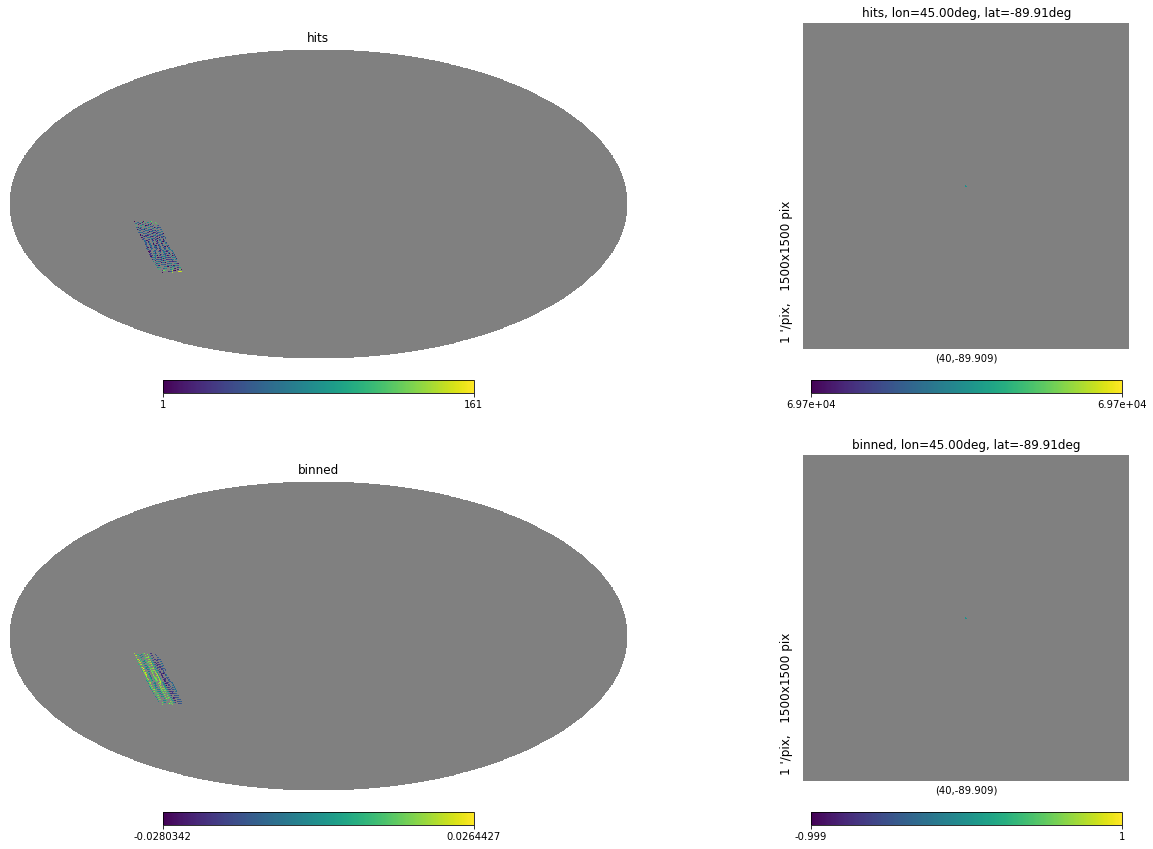

In [18]:
#Plot the map!

plt.figure(figsize=[18, 12])
hits = hp.read_map("./map/hits.fits")
imax = np.argmax(hits)
lon, lat = hp.pix2ang(hp.get_nside(hits), imax, lonlat=True)
crop = np.where(hits == 0)
hits[crop] = hp.UNSEEN
hp.mollview(hits, xsize=1200, sub=[2, 2, 1], title="hits")
hp.gnomview(
    hits,
    rot=(lon-5, lat),
    xsize=1500,
    reso=1.0,
    sub=[2, 2, 2],
    title="hits, lon={:.2f}deg, lat={:.2f}deg".format(lon, lat),
)

binned = hp.read_map("./map/binned.fits")
binned[binned == 0] = hp.UNSEEN
hp.mollview(binned, xsize=1200, sub=[2, 2, 3], title="binned")
hp.gnomview(
    binned,
    rot=(lon-5, lat),
    xsize=1500,
    reso=1.0,
    sub=[2, 2, 4],
    title="binned, lon={:.2f}deg, lat={:.2f}deg".format(lon, lat),
)

<font size=3>The top row contains hit maps and the bottom row contains the binned maps. If it looks weird due to the line spacing, it's probably because this observation was a vibration test run, where the telescope slews back and forth really fast instead of scanning a complete patch.</font>

<font size=3>Now let's plot the real and simulated TODs.</font>

Text(0, 0.5, 'ADC counts')

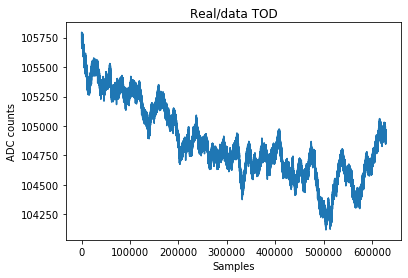

In [19]:
#Actual data TOD loaded in from the g3 files

data_tod = cache['data_13.10_112.90B-I'] 
plt.plot(data_tod)
plt.title('Real/data TOD')
plt.xlabel('Samples')
plt.ylabel('ADC counts')

Text(0.5, 0, 'Samples')

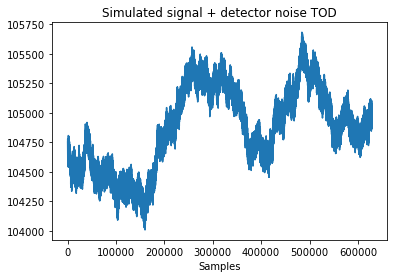

In [20]:
#Simulated TOD, obtained by scanning the Planck temperature map plus some detector noise
 
simulated_tod = cache['mc1_13.10_112.90B']

#Set up some fake gain for spectra plotting purposes for now. TOAST has an operator for gain application
data_max = max(data_tod)
data_min = min(data_tod)
data_mean = np.mean(data_tod)
sim_max = max(simulated_tod)
sim_min = min(simulated_tod)
conversion = (data_max - data_min) / (sim_max - sim_min)

cache['mc1_13.10_112.90B'] = cache['mc1_13.10_112.90B']*conversion + data_mean

plt.plot(cache['mc1_13.10_112.90B'])
plt.title('Simulated signal + detector noise TOD')
plt.xlabel('Samples')

<font size=3>We now have two different flavors of TODs: 'data', which we read in from file, and 'mc1' which we simulated. The SA operators currently don't know about 'mc1', so before we apply any subsequent SA operators, we need to make that prefix known to them. We should probably discuss the best way to do this, but for now I will do it manually to show how subsequent SA operators should behave on new TOD flavors generated by TOAST. This isn't how we'll do it eventually, so feel free to ignore the next cell.</font>

In [21]:
### Temporary fix for demonstration purposes, feel free to skip ###

sa_obs.tod_list.update_tod_list(sims_prefix)
input_name_list = sa_obs.tod_list.get_input_name_list()

for key in cache.keys():
    if input_name_list[0] in key and toast_dets[0] not in key:
        new_key = key.replace(input_name_list[0]+'_', input_name_list[1]+'_')
        cache[new_key] = cache[key]
    if input_name_list[1] in key:
        cache[key+'-I'] = cache[key]

for tod in sa_obs.tod_list:
    tod.cache = cache

<font size=3>Let's check the top level cache again. Note the two prefixes, "data" and "mc1", correspond to different flavors of the TODs. Shared information like the boresight have been copied from one TOD to the other, thereby preserving modularity. When SA operators iterate through this new TOD list, they will know how to access each flavor based on the prefixes. </font>

In [22]:
cache.keys()

['common_flags',
 'data_13.10_112.90B-I',
 'data_13.10_112.90B-Q',
 'data_acu_seq',
 'data_az_command',
 'data_az_pos',
 'data_az_rate',
 'data_az_rate_command',
 'data_bolo_time',
 'data_boresight',
 'data_boresight_azel',
 'data_common_flags',
 'data_corrected_antenna_time_mjd',
 'data_corrected_az_pos',
 'data_corrected_el_pos',
 'data_el_command',
 'data_el_pos',
 'data_el_rate',
 'data_el_rate_command',
 'data_flags_13.10_112.90B',
 'data_frame_faulty',
 'data_frame_total',
 'data_gcp_gaps',
 'data_gcp_gaps_time',
 'data_in_control',
 'data_reverse_time_indices',
 'data_scan_flag',
 'data_state',
 'flags_13.10_112.90B',
 'mc1_13.10_112.90B',
 'mc1_13.10_112.90B-I',
 'mc1_acu_seq',
 'mc1_az_command',
 'mc1_az_pos',
 'mc1_az_rate',
 'mc1_az_rate_command',
 'mc1_bolo_time',
 'mc1_boresight',
 'mc1_boresight_azel',
 'mc1_common_flags',
 'mc1_corrected_antenna_time_mjd',
 'mc1_corrected_az_pos',
 'mc1_corrected_el_pos',
 'mc1_el_command',
 'mc1_el_pos',
 'mc1_el_rate',
 'mc1_el_rate_co

<font size=3>To bring things back full circle, let's apply another SA operator to represent the timestream filtering that would take place after the simulations are done. OperatorTODEvalSpectrum computes the spectrum of all detectors in all TODs of the list. In this example we just have one detector and two TODs, so we should get back two spectra plots.</font>

In [23]:
#Set where our plots go

file_factory = sa_op.PlotFileFactoryFlatDirectory(root = './spec')

#Compute the spectrum, looping over all dets in all TODs

compute_spectrum = sa_op.OperatorTODEvalSpectrum(
    tod_attr='I',
    eval_attr_name=None,
    tod_unit='ADC',
    scan_mask_df=1,
    scan_freq=None, 
    plot_file_factory=file_factory,
    plot_file_suffix=None,
    plot_kwds={},
    compute_subscans=False,
    perform_fit=True,
    detrend_per_subscan=False,
)

compute_spectrum.filter_obs(sa_obs)

INFO: looking for TES 13.10_112.90B
Looking for NaNs 0


wrote ./spec/20100857.5/pb2a_13.10_112.90B_unfilter_I_spectrum.png


INFO: looking for TES 13.10_112.90B
Looking for NaNs 0


wrote ./spec/20100857.5/pb2a_13.10_112.90B_unfilter_I_spectrum.png


<font size=3>The code currently writes both plots to the same file, so I saved them separately instead.</font>

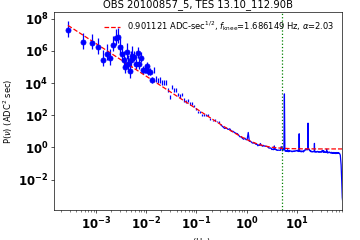

In [24]:
from IPython.display import Image
Image(filename='./spec/20100857.5/data_spec.png') 

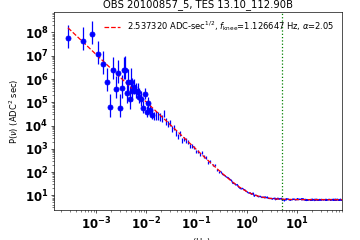

In [25]:
Image(filename='./spec/20100857.5/mc1_spec.png') 

<font size=3>We get two spectra as expected, one for actual data (top) and one for our simulation (bottom). I made up some (probably outrageous) noise properties and did an awkward gain conversion, so I wouldn't analyze the second spectra too closely. This is just a demonstration of how things could work.</font>

<font size=3>Thanks for reading!</font>